If you think it's useful, give me an upvote, thanks.

CenterNet Paper : https://arxiv.org/pdf/1904.07850.pdf

Author repo : https://github.com/xingyizhou/CenterNet

Keras repo : https://github.com/see--/keras-centernet

In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from glob import glob
from math import floor
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import keras
from keras.layers import Dense, Activation, Input, Conv2D, BatchNormalization, Add, UpSampling2D, ZeroPadding2D, Lambda
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import gc
import os

PATH = '/home/hy/pkuad/'
os.listdir(PATH)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/hy/anaconda3/envs/badeda-tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hy/anaconda3/envs/badeda-tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hy/anaconda3/envs/badeda-tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hy/anaconda3/envs

In [2]:
train = pd.read_csv('/home/hy/pkuad/train.csv')
test = pd.read_csv('/home/hy/pkuad/sample_submission.csv')

# I - Main

In [3]:
# def main():
#     # 1. set heads of HourglassNet
#     kwargs = {
#             'num_stacks': 2,
#             'cnv_dim': 256,
#             'inres': (512, 512),
#             }
#     heads = {
#             'car_pose': 6,
#             'confidence': 1
#             }
    
#     # 2. create model
#     model = HourglassNetwork(heads=heads, **kwargs)
#     model.load_weights('../input/centernet-objects-as-points/centernet_weights.hdf5', by_name=True)
    
#     # 3. train
#     train_model(model, epoch=3, batch_size=8)
    
#     # 4.predict
#     predict(model)

# II - Preprocessing


## 1. mutual conversion from strings to coordinates

In [4]:
def str_to_coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def coords_to_str(coords):
    s = []
    for c in coords:
        for n in range(7):
            s.append(str(c[n]))
    return ' '.join(s)

## 2. convert world coordinates to pixel coordinates

In [5]:
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

def pixel_coords(s):
    coords = str_to_coords(s)
    xc = [c['x'] for c in coords]
    yc = [c['y'] for c in coords]
    zc = [c['z'] for c in coords]
    P = np.array(list(zip(xc, yc, zc))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    u = img_p[:, 0]
    v = img_p[:, 1]
    zc = img_p[:, 2]
    return u, v

## 3. resize image
> Input of CenterNet: 512 x 512 x 3 (W, H, 3)

In [6]:
#def resize_image(img, input_width = 512, input_height = 512):
def resize_image(img, input_width = 2049, input_height = 683):
    img = cv2.resize(img, (input_width, input_height))
    return (img / 255).astype('float32')

## 4. create mask images

In [7]:
def CreateMaskImages(imageName):

    trainimage = cv2.imread(PATH  + "/train_images/" + imageName + '.jpg')
    imagemask = cv2.imread(PATH + "/train_masks/" + imageName + ".jpg",0)
    try:
        imagemaskinv = cv2.bitwise_not(imagemask)
        res = cv2.bitwise_and(trainimage,trainimage,mask = imagemaskinv)
        
        # cut upper half,because it doesn't contain cars.
        res = res[res.shape[0] // 2:]
        return res
    except:
        trainimage = trainimage[trainimage.shape[0] // 2:]
        return trainimage

## 5. Heatmap of center points: 128 x 128 x 1
> Output of CenterNet: (W/R, H/R, C) - here, R = 4, Classification C = 1. 
>
>(Center points with gaussian distributions is necessary to reduce the training loss when the model detect the points near the exact center.)

In [8]:
def heatmap(u, v, output_width=128, output_height=128, sigma=1):
    def get_heatmap(p_x, p_y):
        X1 = np.linspace(1, output_width, output_width)
        Y1 = np.linspace(1, output_height, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    output = np.zeros((128,128,1))
    for i in range(len(u)):
        heatmap = get_heatmap(u[i], v[i])
        output[:,:] = np.maximum(output[:,:],heatmap[:,:])
      
    return output

## 6. Regression (yaw, pitch, roll, x, y, z) of the object pose: 128 x 128 x 6
Regressing rotation directly is not a good choice, I may try this way later.

https://www.kaggle.com/diegojohnson/a-way-to-regress-translation-and-rotation

The CenterNet paper use this method:

https://www.kaggle.com/diegojohnson/a-better-way-to-regress-yaw

In [9]:
def pose(s, u, v):
    regr = np.zeros([128, 128, 6], dtype='float32')
    coords = str_to_coords(s)
    for p_x, p_y, regr_dict in zip(u, v, coords):
        if p_x >= 0 and p_x < 128 and p_y >= 0 and p_y < 128:
            regr_dict.pop('id')
            regr[floor(p_y), floor(p_x)] = [regr_dict[n] for n in regr_dict]
            
    # x,y,z devide by 100
    regr[:,:,-3:] /= 100  
    return regr

## 7. Example

In [10]:
def example(i):
    fig, axes = plt.subplots(2, 4,figsize=(20,20))
    plt.subplots_adjust(top=0.5)

    img0 = CreateMaskImages(train['ImageId'][i])
    img1 = resize_image(img0)
    axes[0, 0].set_title('Mask Image as Input')
    axes[0, 0].imshow(img1)

    # Image height: img.shape[0] and v         Image width: img.shape[1] and u
    u, v = pixel_coords(train['PredictionString'][i])
    u = u * 128 / img0.shape[1]
    v = (v - img0.shape[0]) * 128 / img0.shape[0]
    hm = np.squeeze(heatmap(u,v))
    axes[0, 1].set_title('Heatmap of Center Points as Output')
    axes[0, 1].imshow(hm)

    regr = pose(train['PredictionString'][i], u,v)
    axes[0, 2].set_title('Yaw - Ground Truth')
    axes[0, 2].imshow(regr[..., 0])

    axes[0, 3].set_title('Pitch - Ground Truth')
    axes[0, 3].imshow(regr[..., 1])

    axes[1, 0].set_title('Roll - Ground Truth')
    axes[1, 0].imshow(regr[..., 2])

    axes[1, 1].set_title('X - Ground Truth')
    axes[1, 1].imshow(regr[..., 3])

    axes[1, 2].set_title('Y - Ground Truth')
    axes[1, 2].imshow(regr[..., 4])

    axes[1, 3].set_title('Z - Ground Truth')
    axes[1, 3].imshow(regr[..., 5])

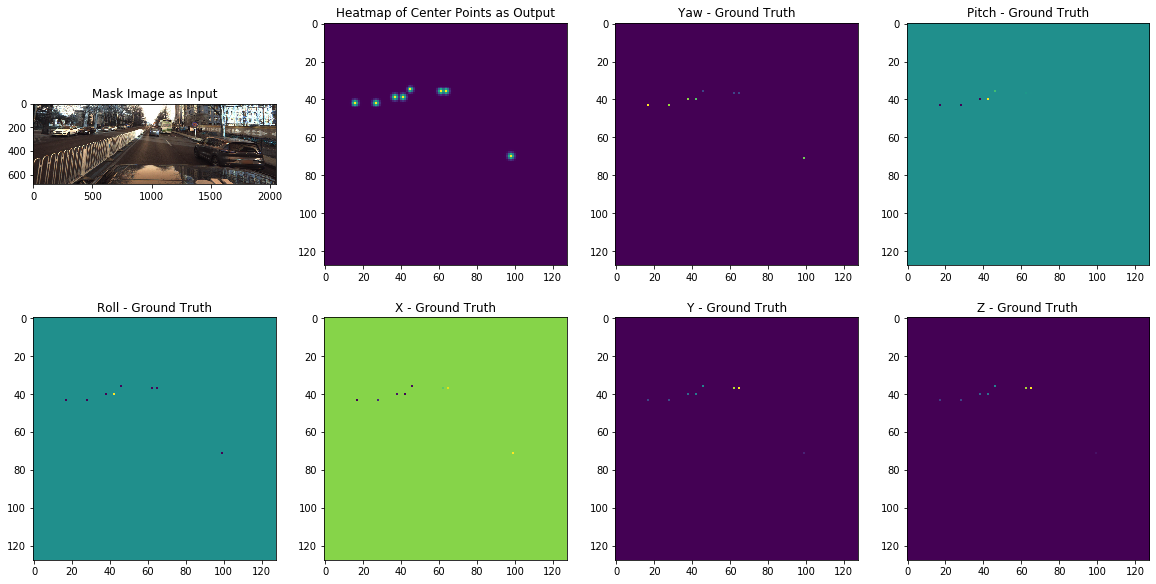

In [11]:
# show example of preprocessed datas, you can input any number you want (<4000)
example(8)

## 6. Data Generator

In [12]:
def train_generator(train, batch_size=3):
    count=0
    X = []
    y1 = []
    y2 = []
    while True:
        for i in range(len(train)):
            img0 = CreateMaskImages(train['ImageId'][i])
            img1 = resize_image(img0)
            X.append(img1)
            
            u, v = pixel_coords(train['PredictionString'][i])
            u = u * 128 / img0.shape[1]
            v = (v - img0.shape[0]) * 128 / img0.shape[0]
            hm = heatmap(u,v)
            y2.append(hm)

            p = pose(train['PredictionString'][i], u, v)
            y1.append(p)

            count+=1
            if count == batch_size:
                X_batch = np.array(X, dtype=np.float32)
                y1_batch = np.array(y1, dtype=np.float32)
                y2_batch = np.array(y2, dtype=np.float32)
                
                del X, y1, y2
                gc.collect()
                
                count = 0
                X = []
                y1 = []
                y2 = []
                
                yield(X_batch, {'car_pose.1.1': y1_batch, 'confidence.1.1': y2_batch})

# III - Model

## 1. backbone - HourglassNet

from https://blog.csdn.net/caikw62/article/details/95673125
![HourglassNet](https://img-blog.csdnimg.cn/20190716171510379.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [13]:
def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), weights=False,
                     dims=[256, 384, 384, 384, 512]):
    """Instantiates the Hourglass architecture.
    Optionally loads weights pre-trained on COCO.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
      num_stacks: number of hourglass modules.
      cnv_dim: number of filters after the resolution is decreased.
      inres: network input shape, should be a multiple of 128.
      weights: one of `None` (random initialization),
            'ctdet_coco' (pre-training on COCO for 2D object detection),
            'hpdet_coco' (pre-training on COCO for human pose detection),
            or the path to the weights file to be loaded.
      dims: numbers of channels in the hourglass blocks.
    # Returns
      A Keras model instance.
    # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
    """
    
    input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
    inter = pre(input_layer, cnv_dim)
    prev_inter = None
    outputs = []
    for i in range(num_stacks):
        prev_inter = inter
        _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
        if i == 1:
            outputs.extend(_heads)
        if i < num_stacks - 1:
            inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
            inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)

            cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
            cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)

            inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
            inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
            inter = residual(inter, cnv_dim, 'inters.%d' % i)

    model = Model(inputs=input_layer, outputs=outputs)

    # load weights
    if weights:
        weights_path = get_file('HourglassNet.hdf5',
                          'https://github.com/see--/keras-centernet/releases/download/0.1.0/ctdet_coco_hg.hdf5',
                          cache_subdir='hourglassnet', 
                          file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')
        model.load_weights(weights_path, by_name=True)

    return model

In [14]:
def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
    # create left features , f1, f2, f4, f8, f16 and f32
    lfs = left_features(bottom, hgid, dims)

    # create right features, connect with left features
    rf1 = right_features(lfs, hgid, dims)
    rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

    # add 1x1 conv with two heads, inter is sent to next stage
    # head_parts is used for intermediate supervision
    heads = create_heads(heads, rf1, hgid)
    return heads, rf1

![convolution](https://img-blog.csdnimg.cn/20190716171120608.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [15]:
def convolution(_x, k, out_dim, name, stride=1):
    padding = (k - 1) // 2
    _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
    _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

![residual](https://img-blog.csdnimg.cn/20190716171157803.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [16]:
def residual(_x, out_dim, name, stride=1):
    shortcut = _x
    num_channels = K.int_shape(shortcut)[-1]
    _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
    _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
    _x = Activation('relu', name=name + '.relu1')(_x)

    _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

    if num_channels != out_dim or stride != 1:
        shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
            shortcut)
        shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

    _x = Add(name=name + '.add')([_x, shortcut])
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

![pre](https://img-blog.csdnimg.cn/20190716170729501.jpg)

In [17]:
def pre(_x, num_channels):
    # front module, input to 1/4 resolution
    _x = convolution(_x, 7, 128, name='pre.0', stride=2)
    _x = residual(_x, num_channels, name='pre.1', stride=2)
    return _x

In [18]:
def left_features(bottom, hgid, dims):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8, f16, f32 : 1, 1/2, 1/4 1/8, 1/16, 1/32 resolution
    # 5 times reduce/increase: (256, 384, 384, 384, 512)
    features = [bottom]
    for kk, nh in enumerate(dims):
        pow_str = ''
        for _ in range(kk):
            pow_str += '.center'
        _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
        _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
        features.append(_x)
    return features

In [19]:
def connect_left_right(left, right, num_channels, num_channels_next, name):
    # left: 2 residual modules
    left = residual(left, num_channels_next, name=name + 'skip.0')
    left = residual(left, num_channels_next, name=name + 'skip.1')

    # up: 2 times residual & nearest neighbour
    out = residual(right, num_channels, name=name + 'out.0')
    out = residual(out, num_channels_next, name=name + 'out.1')
    out = UpSampling2D(name=name + 'out.upsampleNN')(out)
    out = Add(name=name + 'out.add')([left, out])
    return out

In [20]:
def bottleneck_layer(_x, num_channels, hgid):
    # 4 residual blocks with 512 channels in the middle
    pow_str = 'center.' * 5
    _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
    return _x

In [21]:
def right_features(leftfeatures, hgid, dims):
    rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
    for kk in reversed(range(len(dims))):
        pow_str = ''
        for _ in range(kk):
            pow_str += 'center.'
        rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
    return rf

In [22]:
def create_heads(heads, rf1, hgid):
    _heads = []
    for head in sorted(heads):
        num_channels = heads[head]
        _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
        _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
        if head == 'confidence':
            _x = Conv2D(num_channels, 1, activation='sigmoid', use_bias=True, name=head + '.%d.1' % hgid)(_x)
        else:
            _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
        _heads.append(_x)
    return _heads

## 2. Decode

In [23]:
# use maxpooling as nms
def _nms(heat, kernel=3):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep

In [24]:
def _ctdet_decode(hm, reg, k=100, output_stride=4):
    hm = _nms(hm)
    hm_shape = K.shape(hm)
    reg_shape = K.shape(reg)
    batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

    hm_flat = K.reshape(hm, (batch, -1))
    reg_flat = K.reshape(reg, (reg_shape[0], -1, reg_shape[-1]))
    
    def _process_sample(args):
        _hm, _reg = args
        _scores, _inds = tf.nn.top_k(_hm, k=k, sorted=True)
        _inds = K.cast(_inds / cat, 'int32')
        _reg = K.gather(_reg, _inds)
        
        # get yaw, pitch, roll, x, y, z from regression
        yaw =  _reg[..., 0]
        pitch =  _reg[..., 1]
        roll =  _reg[..., 2]
        x =  _reg[..., 3] * 100
        y =  _reg[..., 4] * 100
        z =  _reg[..., 5] * 100

        _detection = K.stack([yaw, pitch, roll, x, y, z, _scores], -1)
        return _detection
    
    detections = K.map_fn(_process_sample, [hm_flat, reg_flat], dtype=K.floatx())
    return detections

In [25]:
def CtDetDecode(model, hm_index=1, reg_index=0, k=100, output_stride=4):
    def _decode(args):
        hm, reg = args
        return _ctdet_decode(hm, reg, k=k, output_stride=output_stride)
    output = Lambda(_decode)([model.outputs[i] for i in [hm_index, reg_index]])
    model = Model(model.input, output)
    return model

# IV - Train

In [26]:
def train_model(model,epoch, batch_size = 4):
    # 1. choose the layers you want to train
    n = 0
    for layer in model.layers:
        layer.trainable = False

        n += 1
        if n == 500:
            break
    
    # 2. define loss function
    def focal_loss(hm_true, hm_pred):
        pos_mask = tf.cast(tf.equal(hm_true, 1), tf.float32)
        neg_mask = tf.cast(tf.less(hm_true, 1), tf.float32)
        neg_weights = tf.pow(1 - hm_true, 4)

        pos_loss = -tf.math.log(tf.clip_by_value(hm_pred, 1e-4, 1)) * tf.pow(1 - hm_pred, 2) * pos_mask
        neg_loss = -tf.math.log(tf.clip_by_value(1 - hm_pred, 1e-4, 1)) * tf.pow(hm_pred, 2) * neg_weights * neg_mask

        num_pos = tf.reduce_sum(pos_mask)
        pos_loss = tf.reduce_sum(pos_loss)
        neg_loss = tf.reduce_sum(neg_loss)

        cls_loss = tf.cond(tf.greater(num_pos, 0), lambda: (pos_loss + neg_loss) / num_pos, lambda: neg_loss)
        return cls_loss
    
    def l1_loss(y_true, y_pred):
        mask = tf.zeros_like(y_true, dtype=tf.float32)
        mask = tf.equal(y_true, mask)
        mask = tf.cast(mask, tf.float32)
        mask = tf.reduce_sum(mask, axis=-1)
        
        one = tf.ones_like(mask)
        zero = tf.zeros_like(mask)
        mask = tf.where(mask == 6, x=zero, y=one)
        mask = tf.tile(tf.expand_dims(mask, axis=-1), (1, 1, 1, 6))
        
        total_loss = tf.reduce_sum(tf.abs(y_true - y_pred * mask))
        reg_loss = total_loss / (tf.reduce_sum(mask) + 1e-4)
        return reg_loss
    
    # 3. compile
    model.compile(optimizer=Adam(),
                   loss={'car_pose.1.1':l1_loss, 'confidence.1.1':focal_loss},
                   loss_weights=[1, 1])
    
    # 4. fit
    history = model.fit_generator(train_generator(train,batch_size=batch_size),
                                  steps_per_epoch = len(train) // batch_size,
                                  epochs = epoch
                                  )
    
    model.save_weights('centernet_weights.hdf5')
    
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.plot(history.history['loss'])

# V - Predict

In [27]:
def TestMaskImages(imageName):

    trainimage = cv2.imread(PATH  + "/test_images/" + imageName + '.jpg')
    imagemask = cv2.imread(PATH + "/test_masks/" + imageName + ".jpg",0)
    try:
        imagemaskinv = cv2.bitwise_not(imagemask)
        res = cv2.bitwise_and(trainimage,trainimage,mask = imagemaskinv)
        res = res[res.shape[0] // 2:]
        return res
    except:
        trainimage = trainimage[trainimage.shape[0] // 2:]
        return trainimage

In [28]:
def predict(model):
    modelx = CtDetDecode(model)
    
    def pred(i):
        img = TestMaskImages(test['ImageId'][i])
        img = resize_image(img)
        X_batch = img[np.newaxis, :]

        detections = modelx.predict(X_batch)
        detections = np.squeeze(detections)


        submission = []
        for d in detections:
            yaw, pitch, roll, x, y, z, score = d
            if score < 0.3:
                continue
            else:
                submission.append(d)

        Prediction_string = coords_to_str(submission)
        test['PredictionString'][i] = Prediction_string

    for i in tqdm(range(len(test))):
        pred(i)
        
    test.to_csv('submission.csv', index=False)

In [30]:
# 1. set heads of HourglassNet
kwargs = {
        'num_stacks': 2,
        'cnv_dim': 256,
        'inres': (2049,683),
        }
heads = {
        'car_pose': 6,
        'confidence': 1
        }

# 2. create model
model = HourglassNetwork(heads=heads, **kwargs)
#model.load_weights('../input/centernet-hg/centernet_weights.hdf5', by_name=True)

# 3. train
train_model(model, epoch=16, batch_size=16)

ValueError: Operands could not be broadcast together with shapes (33, 11, 384) (34, 12, 384)

In [ ]:
# 4.predict
predict(model)

In [ ]:
def str_to_coords_test(s, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def pixel_coords_test(s):
    coords = str_to_coords_test(s)
    xc = [c['x'] for c in coords]
    yc = [c['y'] for c in coords]
    zc = [c['z'] for c in coords]
    P = np.array(list(zip(xc, yc, zc))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    u = img_p[:, 0]
    v = img_p[:, 1]
    zc = img_p[:, 2]
    return u, v 

In [ ]:
def predict_example(i):
    fig, axes = plt.subplots(1, 3,figsize=(20,20))
    plt.subplots_adjust(top=0.5)

    img0 = TestMaskImages(test['ImageId'][i])
    img1 = resize_image(img0)
    axes[0].set_title('Input Image')
    axes[0].imshow(img1)

    # Output Heatmap
    X_batch = img1[np.newaxis, :]
    detections = model.predict(X_batch)
    axes[1].set_title('Output Heatmap')
    axes[1].imshow(np.squeeze(detections[1]))

    # Detection Result
    u, v = pixel_coords_test(test['PredictionString'][i])
    u = u * 128 / img0.shape[1]
    v = (v - img0.shape[0]) * 128 / img0.shape[0]
    print(u, v)
    regr = pose(test['PredictionString'][i], u, v)
    axes[2].set_title('Prediction Yaw')
    axes[2].imshow(regr[..., 0])

In [ ]:
predict_example(6)